# Introduction

Suite à notre analyse précédente basée sur le clustering K-means (3_ACP_K-means_Amazing), bien que certains groupes d'utilisateurs aient été identifiés, les résultats obtenus ne se sont pas révélés pleinement satisfaisants. Cette première approche, qui s'appuyait sur un sous-ensemble du jeu de données, filtré par les clients dont le `user_id` se terminait par 1, avait révélé des différences significatives entre certains clusters. Cependant, ces clusters ne parvenaient pas à capturer de manière optimale les subtilités du comportement des utilisateurs, notamment en ce qui concerne leur engagement et leur contribution à la performance globale.

Afin d'approfondir notre compréhension des utilisateurs et de développer des actions marketing plus ciblées, nous avons décidé d'appliquer une nouvelle approche sur l'intégralité du jeu de données. En prenant en compte l'ensemble des utilisateurs, la méthode de Segmentation RFM (Récence, Fréquence, Valeur Monétaire), largement reconnue pour son efficacité dans les stratégies de fidélisation et de gestion de la relation client, se présente comme une solution plus adaptée et particulièrement pertinente.

### Étapes pour appliquer la méthode RFM :
1. **Récence (Recency)** : Nombre de jours depuis la dernière interaction ou achat.
2. **Fréquence (Frequency)** : Nombre de fois qu'un utilisateur a interagi ou acheté.
3. **Valeur Monétaire (Monetary Value)** : Montant total dépensé par l'utilisateur.

### Calcul des Scores RFM :
1. **Récence** : Utiliser la colonne `days_since_last_purchase`.
2. **Fréquence** : Utiliser les colonnes de fréquence des interactions (`number_of_sessions_2m`, `number_of_sessions_5m`, etc.).
3. **Valeur Monétaire** : Utiliser `total_purchase_value`.


En conséquence, nous allons explorer cette méthode pour obtenir une segmentation plus pertinente et alignée sur nos objectifs commerciaux.


# Importation des bibliothèques nécessaires

In [1]:

import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.tree import plot_tree



In [4]:
df = pd.read_parquet('data/full_df_output.parquet')

In [5]:
df.shape

(846603, 24)

# Mise en œuvre de la segmentation RFM et évaluation des clusters


In [6]:
# Conserver uniquement les colonnes nécessaires dans le DataFrame
df_reduit = df[['days_since_last_purchase', 'number_of_sessions_7m', 'total_purchase_value']].copy()

# Calcul des scores RFM
df_reduit['R_Score'] = pd.qcut(df_reduit['days_since_last_purchase'], q=4, labels=[4, 3, 2, 1])
df_reduit['F_Score'] = pd.qcut(df_reduit['number_of_sessions_7m'], q=4, labels=[1, 2, 3, 4])
df_reduit['M_Score'] = pd.qcut(df_reduit['total_purchase_value'], q=4, labels=[1, 2, 3, 4])


In [7]:
# Préparation des données pour le clustering
X = df_reduit[['R_Score', 'F_Score', 'M_Score']].astype(int)

# Échantillonnage pour le développement et ajustement des hyperparamètres (10% des données)

In [8]:

df_sampled = df_reduit.sample(frac=0.1, random_state=42)
X_sampled = df_sampled[['R_Score', 'F_Score', 'M_Score']].astype(int)

In [9]:

# 4. Application de MiniBatchKMeans sur l'échantillon pour ajuster les paramètres
silhouette_scores = []
range_n_clusters = range(2, 12)  # Tester entre 3 et 17 clusters

In [10]:
for n_clusters in range_n_clusters:
    # Initialisation de MiniBatchKMeans avec des paramètres ajustés
    kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,       # Nombre de clusters
        random_state=42,             # Graine pour reproductibilité
        batch_size=500,              # Taille des mini-lots réduite
        max_iter=50,                 # Réduire le nombre d'itérations pour optimiser le temps
        init='k-means++'             # Initialisation optimisée
    )
    
    # Exécution du clustering sur l'échantillon
    cluster_labels = kmeans.fit_predict(X_sampled)
    
    # Calcul du score de silhouette pour évaluer la qualité du clustering
    silhouette_avg = silhouette_score(X_sampled, cluster_labels)
    
    # Ajout du score dans la liste
    silhouette_scores.append(silhouette_avg)

# Visualisation de l'évolution de l'indice de silhouette en fonction du nombre de clusters

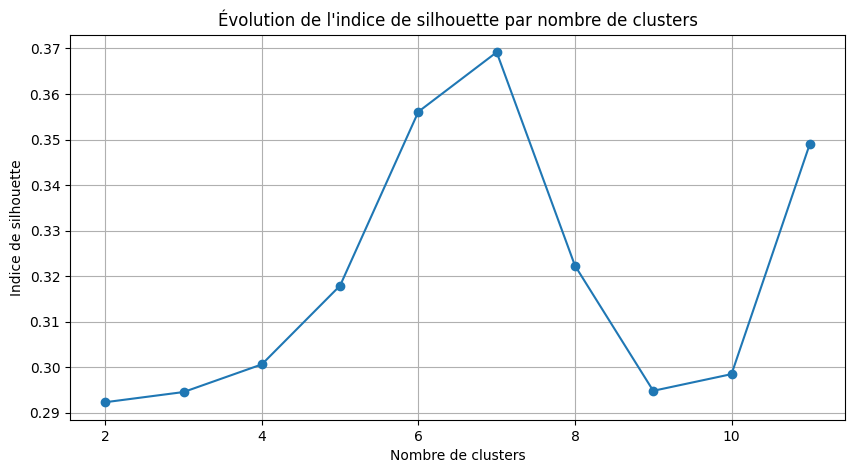

In [11]:
# Graphique de l'évolution de l'indice de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Évolution de l'indice de silhouette par nombre de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de silhouette")
plt.grid(True)
plt.show()



1. **Indice de silhouette** :
   - Un indice de silhouette proche de 1 indique que les clusters sont bien séparés et denses.
   - Un indice proche de 0 signifie que les clusters se chevauchent ou ne sont pas clairement distincts.
   - Des valeurs négatives (bien qu'il n'y en ait pas ici) indiquent que des points sont probablement affectés au mauvais cluster.

2. **Nombre de clusters optimal** :
   Nous observons un pic de l'indice de silhouette autour de 7 clusters, ce qui nous fait penser que 7 clusters pourraient être un bon choix pour une segmentation optimale selon cet indicateur. Cependant, Si nous souhaitons aller plus loin dans la granularité de l'analyse, tester avec 8 ou 9 clusters pourrait nous offrir une segmentation plus détaillée des clients, en prenant en compte des critères comme les gammes de produits ou la fréquence des achats.



In [12]:
# Clustering avec le nombre optimal de clusters trouvé
optimal_clusters = 7
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_reduit['cluster'] = kmeans.fit_predict(X)

# Visualisation 3D du clustering RFM avec le nombre optimal de clusters

In [13]:
# 8. Application de MiniBatchKMeans sur l'ensemble des données avec le nombre optimal de clusters
kmeans_optimal = MiniBatchKMeans(
    n_clusters=optimal_clusters, 
    random_state=42, 
    batch_size=1000,              # Taille des mini-batches ajustée
    max_iter=100,                 # Nombre d'itérations augmenté pour garantir la convergence sur toutes les données
    # Utiliser tous les cœurs CPU
    init='k-means++'            # Initialisation optimisée
)

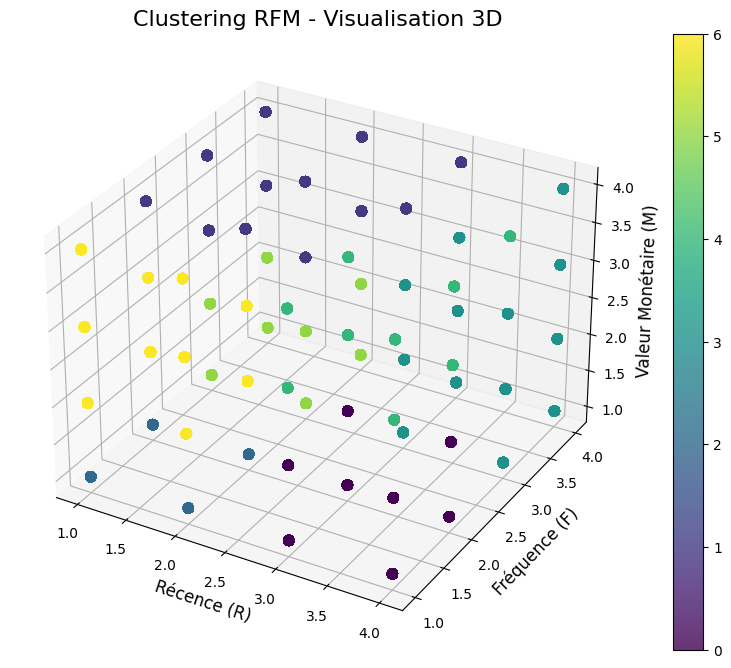

In [14]:


# Graphique 3D du clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Création du nuage de points avec les valeurs R, F, M et les clusters
scatter = ax.scatter(
    df_reduit['R_Score'],  # Récence
    df_reduit['F_Score'],  # Fréquence
    df_reduit['M_Score'],  # Valeur monétaire
    c=df_reduit['cluster'],  # Couleurs selon les clusters
    cmap='viridis',  # Palette de couleurs
    s=50,  # Taille des points
    alpha=0.8  # Transparence des points
)

# Titres et labels
ax.set_title('Clustering RFM - Visualisation 3D', fontsize=16)
ax.set_xlabel('Récence (R)', fontsize=12)
ax.set_ylabel('Fréquence (F)', fontsize=12)
ax.set_zlabel('Valeur Monétaire (M)', fontsize=12)

# Ajouter la barre de couleurs pour montrer les clusters
plt.colorbar(scatter)

# Afficher le graphique
plt.show()


#  Séparation des données et de la cible pour le modèle de classification 


In [15]:
X = df_reduit[['R_Score', 'F_Score', 'M_Score']]  # Caractéristiques RFM
y = df_reduit['cluster']  # Cible : cluster attribué

In [16]:
# Division des données en ensembles d'entraînement et de test
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Création et entraînement du modèle Decision Tree

In [17]:

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

#  Prédiction sur l'ensemble de test 

In [18]:

predictions = tree.predict(data_test)

# Évaluation du modèle (accuracy) 

In [19]:

accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


# Afficher le rapport de classification et la matrice de confusion



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29081
           1       0.82      0.88      0.85     37280
           2       1.00      1.00      1.00     10269
           3       1.00      0.86      0.93     30440
           4       1.00      0.86      0.92     20382
           5       1.00      1.00      1.00     16497
           6       0.85      1.00      0.92     25372

    accuracy                           0.93    169321
   macro avg       0.95      0.94      0.95    169321
weighted avg       0.94      0.93      0.93    169321


Confusion Matrix:


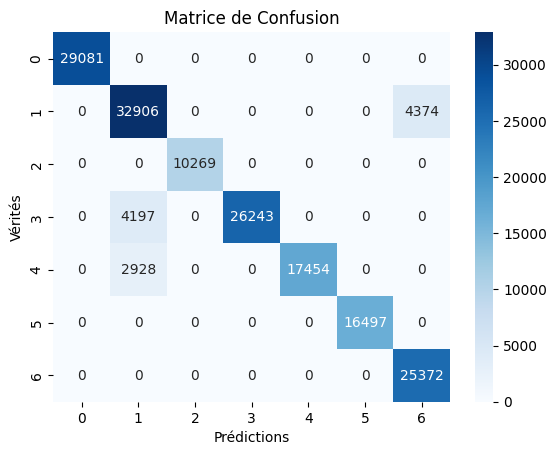

In [20]:
print("\nClassification Report:")
print(classification_report(target_test, predictions))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(target_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()



À partir de la matrice de confusion, nous pouvons tirer des conclusions importantes sur les performances de notre modèle de classification.

Tout d'abord, nous remarquons que pour la **classe 0**, le modèle a correctement prédit **29081** instances, ce qui montre une excellente performance, sans erreurs de classification pour cette classe.

Pour la **classe 1**, bien que le modèle ait correctement prédit **32906** instances, nous observons **4374 erreurs** où les instances de la classe 1 ont été mal classées comme appartenant à la classe 6. Cela montre un chevauchement significatif entre ces deux classes, ce qui pourrait indiquer que ces classes partagent des caractéristiques similaires dans les données. Malgré cela, le modèle reste performant avec une forte exactitude pour cette classe.

La **classe 2** a également été bien classifiée, avec **10269** prédictions correctes et aucune confusion avec les autres classes, indiquant une précision et un rappel très élevés pour cette classe.

Pour la **classe 3**, le modèle a correctement prédit **26243** instances, mais nous observons que **4197** instances de la classe 3 ont été mal classées comme appartenant à la classe 1. Cela pourrait indiquer un problème de différenciation entre ces deux classes, et cela pourrait expliquer pourquoi la précision pour la classe 3 pourrait être légèrement plus faible.

La **classe 4** a également posé des problèmes, avec **2928** instances mal classées comme appartenant à la classe 1, bien que **17454** instances aient été correctement classées. Il est donc nécessaire d'améliorer la distinction entre ces classes.

Les **classes 5 et 6** montrent également des résultats encourageants, avec **16497** prédictions correctes pour la classe 5 et **25372** pour la classe 6, bien qu'il y ait encore quelques erreurs, notamment avec les chevauchements avec d'autres classes.

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

Globalement, avec une **accuracy de 0.93**, les performances du modèle sont solides. Cependant, des améliorations sont possibles, en particulier pour mieux distinguer la **classe 1** de la **classe 6**, ainsi que pour corriger les confusions entre les **classes 3** et **1**.

</div>



# Visualisation de l'arbre de décision


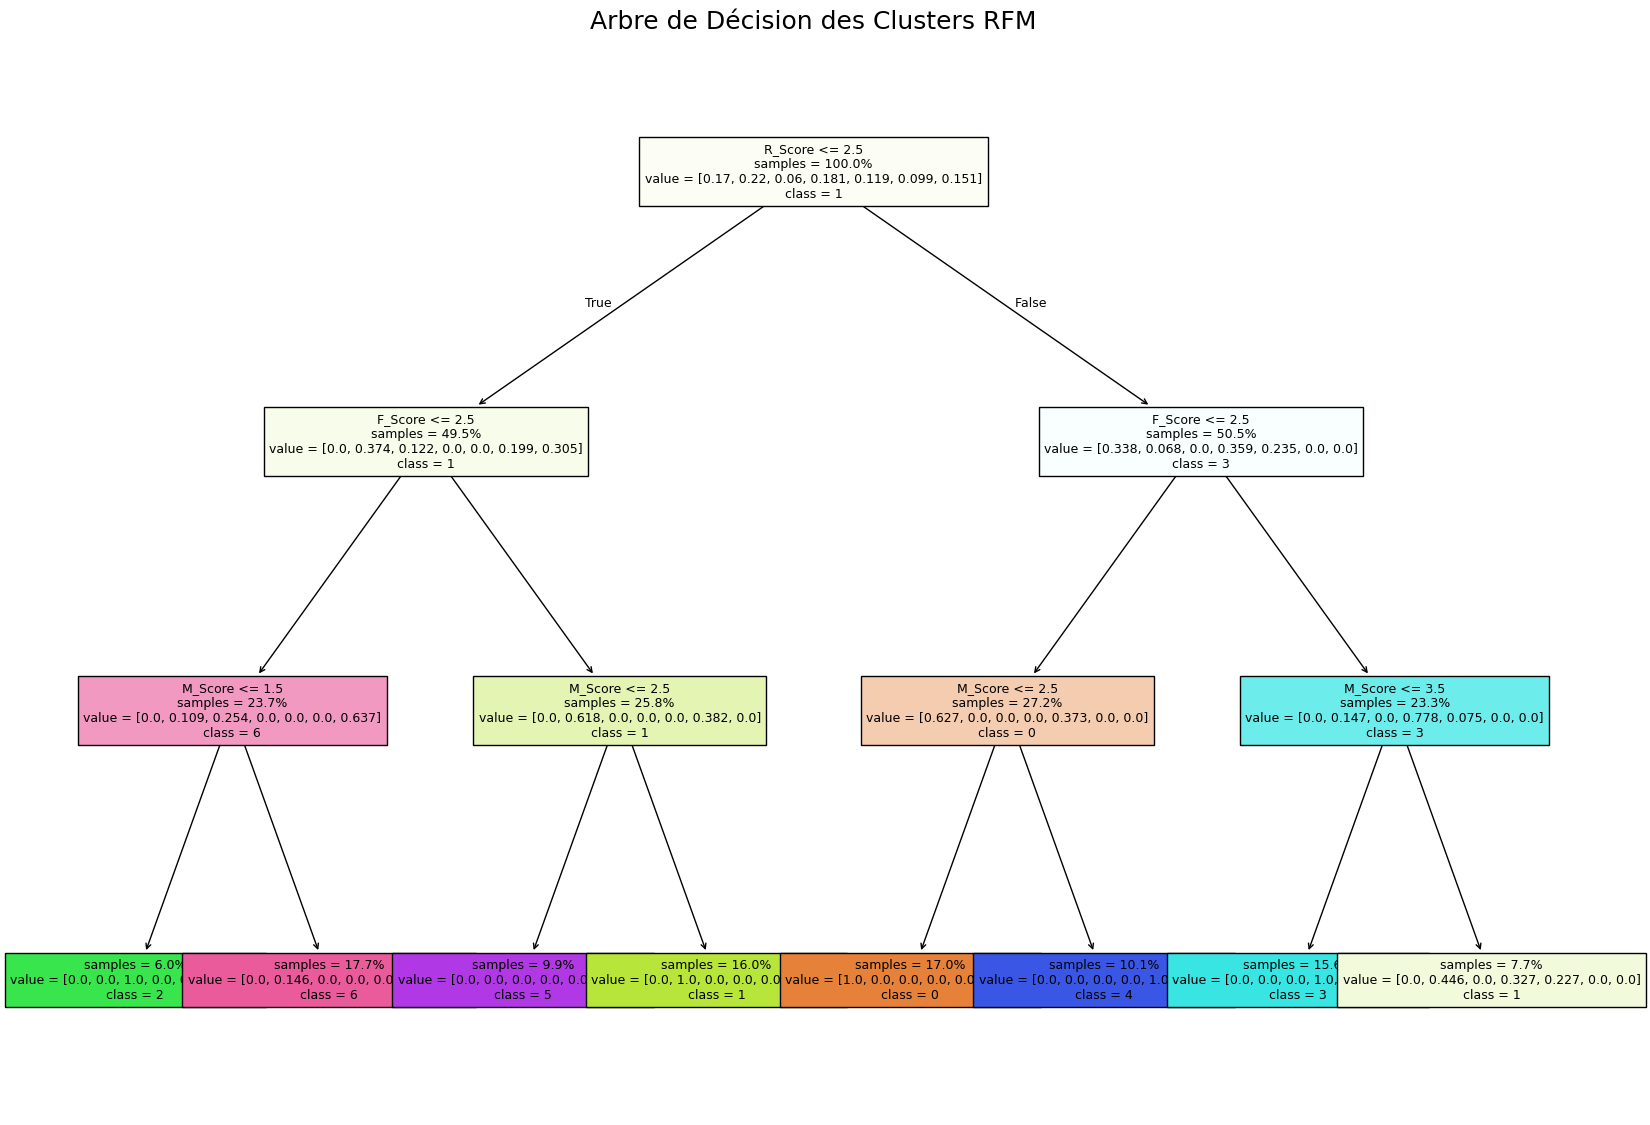

In [21]:
# Entraînement de l'arbre de décision (comme dans la partie précédente du code)
# Nommons l'arbre de décision "clf" pour éviter le conflit avec le module "tree"
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(data_train, target_train)

# Définir les noms des features et des classes pour l'affichage de l'arbre
feature_names = ['R_Score', 'F_Score', 'M_Score']
class_names = [str(cls) for cls in clf.classes_]  # Utiliser l'objet "clf" qui a été formé

# Visualisation de l'arbre de décision avec une taille de figure ajustée
_, ax = plt.subplots(figsize=(20, 14), dpi=100)  # Augmentation de la taille et de la résolution de la figure
plot_tree(
    clf,  # Utilisation du modèle "clf" ici
    feature_names=feature_names,
    class_names=class_names,
    impurity=False,
    filled=True,
    ax=ax,
    fontsize=9, 
    proportion=True
)

plt.title('Arbre de Décision des Clusters RFM', fontsize=18)
plt.show()


En regardant cet arbre de décision, nous pouvons associer différents groupes de clients à des animaux pour mieux visualiser leurs comportements en fonction de leurs scores RFM (Récence, Fréquence, Montant) et des 7 classes identifiées.

### Classification des clients selon les animaux :

- **Classe 0** (Clients avec un **R_Score ≤ 2.5**, **F_Score ≤ 2.5** et **M_Score > 2.5**) :
   - Ces clients sont comme des **lions 🦁**. Ils sont puissants et dominants, effectuant de gros achats tout en étant relativement récents. Ce sont des clients à haute valeur ajoutée qu'il faut choyer pour maximiser leur fidélité. 

- **Classe 1** (Clients avec un **R_Score ≤ 2.5**, **F_Score > 2.5** et **M_Score ≤ 2.5**) :
   - Ces clients sont comme des **ours 🐻**. Ils reviennent régulièrement et effectuent des achats modérés. Ils ne sont pas aussi dynamiques que les lions, mais leur fidélité en fait un groupe stable à ne pas négliger.

- **Classe 2** (Clients avec un **R_Score ≤ 2.5**, **F_Score ≤ 2.5** et **M_Score ≤ 1.5**) :
   - Ces clients ressemblent à des **écureuils 🐿️**. Ils effectuent de petits achats occasionnels et ne sont pas très actifs. Ils accumulent petit à petit sans faire de grosses dépenses. Il peut être intéressant de les activer davantage pour accroître leur contribution.

- **Classe 3** (Clients avec un **R_Score > 2.5**, **F_Score ≤ 2.5** et **M_Score ≥ 3.5**) :
   - Ce groupe se compare à des **renards 🦊**. Ils sont discrets, mais lorsqu'ils reviennent, ils effectuent des achats importants. Ce sont des clients stratégiques qu’il faut cibler pour des campagnes occasionnelles visant à les faire revenir et dépenser.

- **Classe 4** (Clients avec un **R_Score > 2.5**, **F_Score > 2.5** et **M_Score ≤ 3.5**) :
   - Ils peuvent être vus comme des **castors 🦫**. Ils sont actifs et réguliers dans leurs achats, mais leur contribution monétaire est moyenne. Leurs habitudes sont prévisibles, et ils constituent un groupe fiable pour des programmes de fidélisation à long terme.

- **Classe 5** (Clients avec un **R_Score ≤ 2.5**, **F_Score ≤ 2.5** et **M_Score entre 1.5 et 2.5**) :
   - Ces clients peuvent être comparés à des **chouettes 🦉**. Discrets et relativement silencieux, ils ne reviennent pas souvent, mais leurs achats sont modérés. Ce groupe pourrait nécessiter des campagnes de réengagement pour augmenter la fréquence de leurs achats.

- **Classe 6** (Clients avec un **R_Score ≤ 2.5**, **F_Score ≤ 2.5** et **M_Score ≤ 1.5**) :
   - Ils sont comme des **tortues 🐢**. Ils avancent lentement, avec des achats très peu fréquents et de faible montant. Ces clients ont besoin d'efforts significatifs pour les réactiver ou de stratégies spécifiques pour augmenter leur engagement.

---

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

 L'arbre de décision met en lumière une variété de comportements clients qui peuvent être associés à différents animaux : des **lions 🦁** pour les gros dépensiers récents, aux **tortues 🐢** pour ceux qui sont moins actifs et dépensent peu. Cette segmentation peut aider à personnaliser les stratégies marketing pour chaque groupe, avec un accent particulier sur la fidélisation des **lions 🦁** et des **ours 🐻**, tout en réactivant les **tortues 🐢** et les **chouettes 🦉**.

</div>


# Visualisation de la courbe ROC AUC

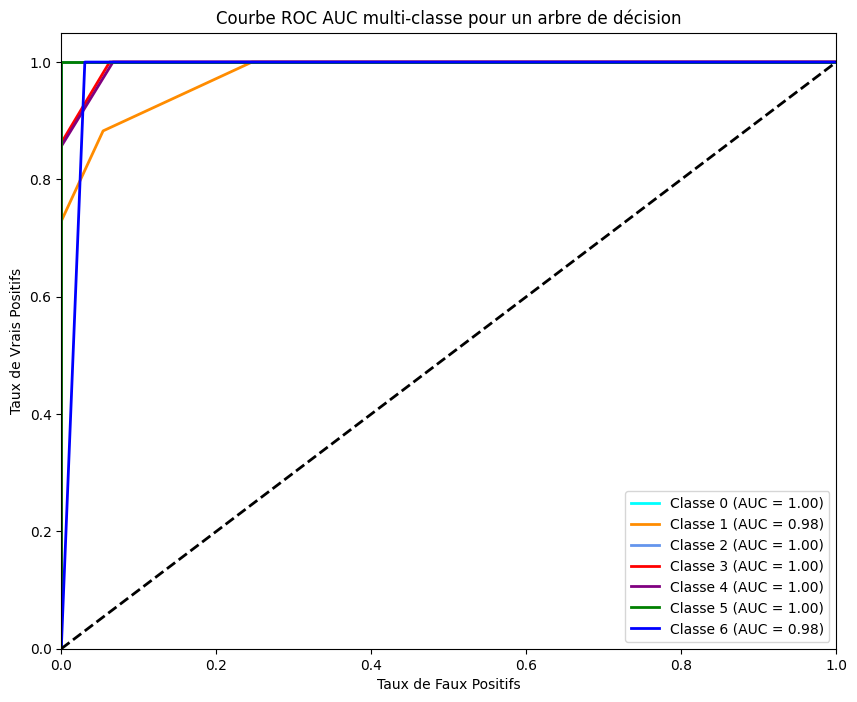

In [23]:

# Si multiclass, binarisation des classes
target_train_bin = label_binarize(target_train, classes=[0, 1, 2, 3, 4, 5, 6])
target_test_bin = label_binarize(target_test, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = target_train_bin.shape[1]

# Obtenir les probabilités de prédiction
y_score = clf.predict_proba(data_test)

# Initialiser les variables pour la courbe ROC AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculer la courbe ROC et AUC pour chaque classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer la courbe ROC pour chaque classe
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'blue']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             lw=2, label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

# Graphique de la courbe ROC
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC AUC multi-classe pour un arbre de décision')
plt.legend(loc="lower right")
plt.show()


L’interprétation de cette courbe ROC AUC pour un arbre de décision multi-classe repose sur les performances du modèle en termes de capacité à séparer les différentes classes. Chaque courbe ROC trace le taux de vrais positifs (sensitivity) contre le taux de faux positifs (1-specificity), et l’aire sous la courbe (AUC) donne une idée globale des performances du modèle pour chaque classe.

### Analyse des courbes ROC pour chaque classe :

 - . **Classe 0 **lions 🦁** (AUC = 1.00)** : 
   - La courbe ROC pour la classe 0 montre un AUC parfait de 1.00, ce qui signifie que le modèle distingue parfaitement cette classe sans aucune erreur. Cela suggère que le modèle classifie parfaitement les échantillons de cette classe.
   
 - . **Classe 1 ours 🐻 (AUC = 0.98)** :
   - L’AUC de 0.98 pour la classe 1 montre que le modèle est presque parfait pour distinguer cette classe des autres, avec une très légère perte de performance. Le modèle fait très peu d'erreurs lors de la classification des échantillons de la classe 1, mais quelques faux positifs ou faux négatifs subsistent.
   
 - . **Classe 2 écureuils 🐿️ (AUC = 1.00)** :
   - Tout comme la classe 0, la classe 2 a un AUC parfait de 1.00, indiquant que le modèle distingue parfaitement cette classe. Aucune erreur de classification n’est observée pour cette classe.
   
 - . **Classe 3 renards 🦊 (AUC = 1.00)** :
   - L’AUC de 1.00 pour la classe 3 est également parfaite, indiquant que le modèle classe les échantillons de cette classe sans erreur. Le modèle a donc un excellent comportement pour cette classe.
   
 - . **Classe 4 castors 🦫 (AUC = 1.00)** :
   - Comme pour les classes précédentes avec un AUC de 1.00, cela indique que le modèle est capable de séparer parfaitement les échantillons de la classe 4. Pas de faux positifs ni de faux négatifs.
   
 - . **Classe 5 chouettes 🦉 (AUC = 1.00)** :
   - Un autre cas d’AUC parfait. Le modèle se comporte parfaitement pour la classe 5, ce qui suggère une classification sans erreur pour cette classe.
   
 - . **Classe 6 tortues 🐢(AUC = 0.98)** :
   - Comme pour la classe 1, l’AUC pour la classe 6 est très proche de la perfection à 0.98. Cela indique une excellente séparation de cette classe, mais il reste quelques erreurs mineures où des échantillons de la classe 6 sont mal classés ou d’autres classes sont confondues avec la classe 6.

### Interprétation générale :
- **AUC élevé (proche de 1.00)** : Les courbes montrent que le modèle est excellent pour différencier les classes entre elles. Avec des AUC allant de 0.98 à 1.00, cela montre que le modèle a une très bonne capacité discriminante.
- **Classes avec AUC = 1.00** : Les classes 0, 2, 3, 4 et 5 sont parfaitement différenciées par le modèle, ce qui signifie que le modèle n’a fait aucune erreur pour ces classes, que ce soit en faux positifs ou faux négatifs.
- **Classes avec AUC = 0.98** : Les classes 1 et 6 montrent une très légère perte de performance (AUC = 0.98). Cela signifie qu’il y a quelques erreurs de classification, mais globalement, le modèle reste très performant pour ces classes.

---

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

Le modèle d'arbre de décision utilisé pour la classification des clients semble extrêmement performant avec des **AUC très proches de 1.00** pour toutes les classes, suggérant une excellente capacité à classer correctement les échantillons. Pour les classes 1 et 6, de petites améliorations peuvent être apportées, mais les erreurs sont très minimes.

En termes pratiques, cela signifie que le modèle est particulièrement adapté à la segmentation des clients dans le contexte RFM (Récence, Fréquence, Montant), avec une capacité presque parfaite à discriminer les différents types de comportements clients.

<div>